In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs, feature as cfeature
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import re
import xarray as xr
from matplotlib.colors import to_hex
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
import geodatasets
import rasterio
from rasterio.transform import from_origin
import matplotlib.colors as mcolors
from shapely.geometry import box
from scipy.spatial import cKDTree
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm

from scripts.geodata import *

#  Suppress warnings issued by Cartopy when downloading data files
warnings.filterwarnings('ignore')

# reload modules
%load_ext autoreload
%autoreload 2


In [2]:
month_abbr_hydr = {
    'sep': 1,
    'oct': 2,
    'nov': 3,
    'dec': 4,
    'jan': 5,
    'feb': 6,
    'mar': 7,
    'apr': 8,
    'may': 9,
    'jun': 10,
    'jul': 11,
    'aug': 12,
}

## Satellite data to nc:

In [3]:
from collections import defaultdict

# Sentinel-2
path_S2 = '../../../data/Sentinel/'
src_crs = 'EPSG:4326'  # Original CRS (lat/lon) wgs84

satellite_years = [2015, 2016, 2017, 2018, 2019, 2020, 2021]


def organize_rasters_by_hydro_year(path_S2, satellite_years):
    rasters = defaultdict(
        lambda: defaultdict(list))  # Nested dictionary for years and months

    for year in satellite_years:
        folder_path = os.path.join(path_S2, str(year))
        for f in os.listdir(folder_path):
            if f.endswith(".tif"):  # Only process raster files
                # Step 1: Extract the date from the string
                date_str = f.split('_')[3][:8]  # Extract the 8-digit date (YYYYMMDD)
                file_date = datetime.strptime(date_str, "%Y%m%d")  # Convert to datetime object
                
                closest_month, hydro_year = get_hydro_year_and_month(file_date)
                if hydro_year < 2022:
                    rasters[hydro_year][closest_month].append(f)

    return rasters


rasters_all = organize_rasters_by_hydro_year(path_S2, satellite_years)

# Print the organized rasters
for hydro_year, months in rasters_all.items():
    print(f"-----------------\nHydrological Year: {hydro_year}")
    for month, files in months.items():
        print(f"  {month}: {files}")


-----------------
Hydrological Year: 2015
  aug: ['GLF_S2A_MSIL1C_20150806T102016_N0204_R065_T32TMS_20150806T102012_10m_r.tif', 'GLF_S2A_MSIL1C_20150826T102026_N0204_R065_T32TMS_20150826T102655_10m_r.tif']
-----------------
Hydrological Year: 2017
  oct: ['GLF_S2A_MSIL1C_20160929T102022_N0204_R065_T32TMS_20160929T102344_10m_r.tif', 'GLF_S2A_MSIL1C_20161029T102132_N0204_R065_T32TMS_20161029T102445_10m_r.tif']
  sep: ['GLF_S2A_MSIL1C_20160909T102022_N0204_R065_T32TMS_20160909T102108_10m_r.tif']
  jul: ['GLF_S2A_MSIL1C_20170626T102021_N0205_R065_T32TMS_20170626T102321_10m_r.tif', 'GLF_S2A_MSIL1C_20170716T102021_N0205_R065_T32TMS_20170716T102324_10m_r.tif', 'GLF_S2A_MSIL1C_20170706T102021_N0205_R065_T32TMS_20170706T102301_10m_r.tif']
  may: ['GLF_S2A_MSIL1C_20170527T102031_N0205_R065_T32TMS_20170527T102301_10m_r.tif', 'GLF_S2A_MSIL1C_20170517T102031_N0205_R065_T32TMS_20170517T102352_10m_r.tif']
  aug: ['GLF_S2A_MSIL1C_20170805T102031_N0205_R065_T32TMS_20170805T102535_10m_r.tif', 'GLF_S2B_M

### One example of Aletsch:

### Normal:

In [ ]:
# get glacier coordinates:
glacierName = 'aletsch'
year = 2021
month = 'aug'
monthNb = month_abbr_hydr[month]

# get correct raster:
raster_gl = rasters_all[year][month]
if len(raster_gl) > 1:
    raster_gl = os.path.join(path_S2, str(year), raster_gl[0])

filename_nc = f"{glacierName}_{year}_{monthNb}.nc"

path_nc_wgs84 = f"results/nc/var_normal/{glacierName}/wgs84/"
gdf_glacier, gdf_class, snow_cover_glacier, ice_cover_glacier = snowCover(
    path_nc_wgs84, filename_nc)

path_nc_wgs84_corr = f"results/nc/var_corr/{glacierName}/wgs84/"
gdf_glacier, gdf_class_corr, snow_cover_glacier_corr, ice_cover_glacier_corr = snowCover(
    path_nc_wgs84_corr, filename_nc)

# Clip the raster to the glacier extent and resample it to the glacier resolution
gdf_raster = createRaster(raster_gl)
gdf_raster_res = resampleRaster(gdf_glacier, gdf_raster)

In [ ]:
# Create the figure and subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
date_str = raster_gl.split('_')[3][:8]  # Extract the 8-digit date (YYYYMMDD)
file_date = datetime.strptime(date_str, "%Y%m%d")
gl_date = str(year) + '-' + month
plotClasses(gdf_glacier, gdf_class, gdf_class_corr, gdf_raster_res, axs,
            gl_date, file_date)


### Create satellite rasters for all glaciers:

In [ ]:
RUN = False
if RUN:
    glaciers_all = os.listdir('results/nc/var_normal/')
    for hydro_year, months in tqdm(rasters_all.items(),
                                position=0,
                                desc='Hydrological Years'):
        for month, files in tqdm(months.items(),
                                position=1,
                                leave=False,
                                desc='Months'):
            for raster_name in files:
                # Create raster for that year:
                date_str = raster_name.split(
                    '_')[3][:8]  # Extract the 8-digit date (YYYYMMDD)
                file_date = datetime.strptime(date_str, "%Y%m%d")
                raster_gl = os.path.join(path_S2, file_date.strftime('%Y'),
                                        raster_name)

                # This is the longest part of the code
                gdf_raster = createRaster(raster_gl)

                for glacierName in tqdm(glaciers_all,
                                        position=2,
                                        leave=False,
                                        desc='Glaciers'):
                    # Load MB predictions for that year and month
                    monthNb = month_abbr_hydr[month]
                    filename_nc = f"{glacierName}_{hydro_year}_{monthNb}.nc"

                    path_nc_wgs84 = f"results/nc/var_normal/{glacierName}/wgs84/"
                    # Calculate snow cover for glacier
                    gdf_glacier, gdf_class, snow_cover_glacier, ice_cover_glacier = snowCover(
                        path_nc_wgs84, filename_nc)

                    # Clip the raster to the glacier extent and resample it to the glacier resolution
                    gdf_raster_res = resampleRaster(gdf_glacier, gdf_raster)
                    # In case the glacier is outside of the bounds of the raster
                    if gdf_raster_res is 0:
                        continue
                    # In case the raster is empty where the glacier is
                    elif gdf_raster_res is 1:
                        continue
                    else:
                        pass

                    # Save the glacier raster:
                    date_raster = file_date.strftime('%Y_%m_%d')
                    rastername = f'{glacierName}_{date_raster}.geojson'
                    pathSave = os.path.join(path_S2, 'perglacier', rastername)
                    gdf_raster_res.to_file(pathSave, driver="GeoJSON")

## Snow cover:

In [4]:
satellite_years = [2015, 2016, 2017, 2018, 2019, 2020, 2021]
glaciers_all = os.listdir('results/nc/var_normal/')

# first delete results file
if os.path.exists(f'results/snow_cover.csv'):
    os.remove(f'results/snow_cover.csv')

with open(f'results/snow_cover.csv', 'w') as f:
    f.write(
        "year,month,glacier_name,snow_cover_raster,snow_cover_glacier,snow_cover_glacier_corr,ice_cover_raster,ice_cover_glacier,ice_cover_glacier_corr\n"
    )

In [5]:
rasters_resampled = os.listdir(os.path.join(path_S2, 'perglacier'))
rasters_resampled

['plattalva_2019_06_01.geojson',
 'rhone_2021_05_31.geojson',
 'aletsch_2016_10_29.geojson',
 'plattalva_2017_07_16.geojson',
 'plattalva_2020_09_18.geojson',
 'basodino_2015_08_26.geojson',
 'schwarzberg_2020_07_20.geojson',
 'adler_2020_09_18.geojson',
 'claridenL_2021_08_24.geojson',
 'adler_2020_09_03.geojson',
 'basodino_2020_09_03.geojson',
 'claridenU_2018_07_26.geojson',
 'adler_2020_09_13.geojson',
 'claridenL_2017_10_19.geojson',
 'claridenU_2020_09_03.geojson',
 'claridenL_2020_08_09.geojson',
 'schwarzberg_2018_06_21.geojson',
 'aletsch_2020_08_09.geojson',
 'schwarzbach_2020_08_09.geojson',
 'claridenU_2020_07_25.geojson',
 'adler_2019_09_04.geojson',
 'findelen_2018_07_11.geojson',
 'hohlaub_2018_05_07.geojson',
 'schwarzbach_2021_08_24.geojson',
 'adler_2017_10_14.geojson',
 'plattalva_2020_07_05.geojson',
 'limmern_2020_09_18.geojson',
 'schwarzberg_2018_05_07.geojson',
 'schwarzbach_2018_08_20.geojson',
 'gries_2017_07_16.geojson',
 'basodino_2018_05_07.geojson',
 'san

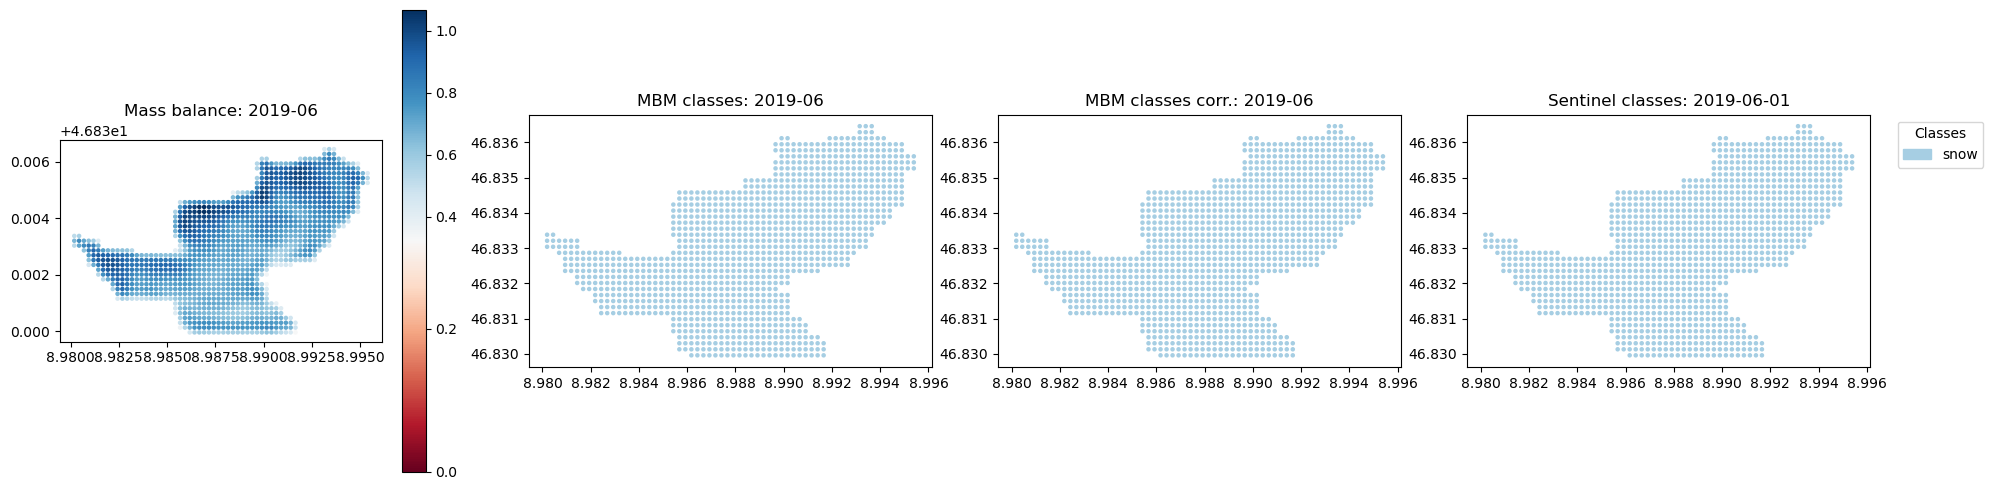

In [11]:
# for raster_res in rasters_resampled:

raster_res = rasters_resampled[0]
match = re.search(r"(\d{4})_(\d{2})_(\d{2})", raster_res)
year, month, day = match.groups()
date = '-'.join(match.groups())
date = datetime.strptime(date, "%Y-%m-%d")
closest_month, hydro_year = get_hydro_year_and_month(date)
monthNb = month_abbr_hydr[closest_month]

glacierName = raster_res.split('_')[0]

gdf_raster_res = gpd.read_file(os.path.join(path_S2, 'perglacier', raster_res))

path_nc_wgs84 = f"results/nc/var_normal/{glacierName}/wgs84/"
path_nc_wgs84_corr = f"results/nc/var_corr/{glacierName}/wgs84/"

# Calculate snow cover for glacier
filename_nc = f"{glacierName}_{hydro_year}_{monthNb}.nc"
gdf_glacier, gdf_class, snow_cover_glacier, ice_cover_glacier = snowCover(
    path_nc_wgs84, filename_nc)

# Corrected for temperature & precipitation
gdf_glacier, gdf_class_corr, snow_cover_glacier_corr, ice_cover_glacier_corr = snowCover(
    path_nc_wgs84_corr, filename_nc)

# Calculate percentage of snow cover (class 1)
snow_cover_raster = gdf_raster_res.data[
    gdf_raster_res.data ==
    1].count() / gdf_raster_res.data.count()
ice_cover_raster = gdf_raster_res.data[
    gdf_raster_res.data ==
    3].count() / gdf_raster_res.data.count()

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
gl_date = str(hydro_year) + '-' + month
plotClasses(gdf_glacier, gdf_class, gdf_class_corr, gdf_raster_res, axs,
            gl_date, date)

In [ ]:

            
                
            



                

                

                # Save the results
                with open(f'results/snow_cover.csv', 'a') as f:
                    f.write(
                        f"{hydro_year},{month},{glacierName}, {snow_cover_raster},{snow_cover_glacier},{snow_cover_glacier_corr}, {ice_cover_raster},{ice_cover_glacier}, {ice_cover_glacier_corr}\n"
                    )

In [ ]:
gdf_raster_res.to_file("output_file.geojson", driver="GeoJSON")


In [ ]:
gdf = gpd.read_file("output_file.geojson")

# plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, column='data', legend=True)
plt.show()

In [ ]:
np.unique(out_of_bounds)

In [ ]:
# read the results
df = pd.read_csv(f'results/snow_cover.csv')

# scatter plot of snow cover
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs[0]
sns.scatterplot(df,
                x='snow_cover_raster',
                y='snow_cover_glacier',
                marker='o',
                hue='glacier_name',
                ax=ax)

# add identity line
x = np.linspace(0, 1, 100)
ax.plot(x, x, 'k--')
ax.set_title('Snow cover')

ax = axs[1]
sns.scatterplot(df,
                x='snow_cover_raster',
                y='snow_cover_glacier_corr',
                marker='o',
                hue='glacier_name',
                ax=ax)

# add identity line
x = np.linspace(0, 1, 100)
ax.plot(x, x, 'k--')
ax.set_title('Snow cover with downscaled T & P')

In [ ]:
# get glacier coordinates:
glacierName = 'sanktanna'
year = 2021

filename_nc = f"{glacierName}_{year}.nc"
path_nc_lv95 = f"results/nc/var_normal/{glacierName}/lv95/"
path_nc_wgs84 = f"results/nc/var_normal/{glacierName}/wgs84/"

# Open xarray:
ds_latlon = xr.open_dataset(path_nc_wgs84 + filename_nc)

# Smoothing
ds_latlon_g = GaussianFilter(ds_latlon)

# Convert to GeoPandas
gdf_glacier, lon, lat = toGeoPandas(ds_latlon_g)

# Make classification map of snow/ice:
# Replace values: below 0 with 3, above 0 with 1
gdf_class = gdf_glacier.copy()
tol = 0
gdf_class.loc[gdf_glacier['data'] > 0 + tol, 'data'] = 1  # Snow
gdf_class.loc[gdf_glacier['data'] <= 0 + tol, 'data'] = 3  # Ice

# Clip the raster to the glacier extent and resample it to the glacier resolution

gdf_raster = createRaster(raster_a_2021)

gdf_raster_res = resampleRaster(gdf_glacier, gdf_raster)

plotClasses(gdf_glacier, gdf_class, gdf_raster_res)

In [ ]:
snow_cover_raster = gdf_raster_res.data[
    gdf_raster_res.data == 1].count() / gdf_raster_res.data.count()
ice_cover_raster = gdf_raster_res.data[
    gdf_raster_res.data == 3].count() / gdf_raster_res.data.count()

snow_cover_raster, ice_cover_raster

### Missed glaciers:

#### Problem 1: Glacier is in regions where raster is NaN

In [ ]:
year = 2015
glacierName = 'taelliboden'
filename_nc = f"{glacierName}_{year}.nc"
path_nc_wgs84 = f"results/nc/var_normal/{glacierName}/wgs84/"
path_nc_wgs84_corr = f"results/nc/var_corr/{glacierName}/wgs84/"

gdf_raster = createRaster(raster_a_2015)

# Calculate snow cover for glacier
gdf_glacier, snow_cover_glacier, ice_cover_glacier = snowCover(
    path_nc_wgs84, filename_nc)
# Corrected for temperature & precipitation
gdf_glacier, snow_cover_glacier_corr, ice_cover_glacier_corr = snowCover(
    path_nc_wgs84_corr, filename_nc)

# Clip the raster to the glacier extent and resample it to the glacier resolution
# gdf_raster_res = resampleRaster(gdf_glacier, gdf_raster)

bounding_box = gdf_glacier.total_bounds  # [minx, miny, maxx, maxy]
raster_bounds = gdf_raster.total_bounds  # [minx, miny, maxx, maxy]

# Check if glacier bounds are within raster bounds
if not (bounding_box[0] >= raster_bounds[0]
        and  # minx of glacier >= minx of raster
        bounding_box[1] >= raster_bounds[1]
        and  # miny of glacier >= miny of raster
        bounding_box[2] <= raster_bounds[2]
        and  # maxx of glacier <= maxx of raster
        bounding_box[3]
        <= raster_bounds[3]  # maxy of glacier <= maxy of raster
        ):
    print(f"Glacier {glacierName} is out of bounds")

bbox_polygon = box(*bounding_box)

# The raster might have no data (NaN values) in the region of the glacier:
bounding_box = [7.8, 45.95854232, 8, 46.1]
bbox_polygon = box(*bounding_box)
gfd_res = gdf_raster[gdf_raster.intersects(bbox_polygon)]
ax = gfd_res.plot(color='blue', alpha=0.5)
gdf_glacier.plot(ax=ax, color='red')

## Transform to tif rasters for QGIS:

### One year:

In [ ]:
glacierName = 'aletsch'
year = 2021

filename_nc = f"{glacierName}_{year}.nc"
path_nc_lv95 = f"results/nc/{glacierName}/lv95/"
path_nc_wgs84 = f"results/nc/{glacierName}/wgs84/"

filename_tif = f"{glacierName}_{year}.tif"
path_tif_wgs84 = f"results/tif/{glacierName}/wgs84/"
path_tif_lv95 = f"results/tif/{glacierName}/lv95/"

createPath(path_tif_lv95)
createPath(path_tif_wgs84)

In [ ]:
gdf, gdf_class, raster_data, extent = TransformToRaster(
    filename_nc, filename_tif, path_nc_wgs84, path_tif_wgs84, path_tif_lv95)

In [ ]:
API_KEY = "000378bd-b0f0-46e2-a46d-f2165b0c6c02"
provider = cx.providers.Stadia.StamenTerrain(api_key=API_KEY)
provider["url"] = provider["url"] + f"?api_key={API_KEY}"

vmin, vmax = gdf.data.min(), gdf.data.max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
gdf_clean = gdf.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    cmap="RdBu",  # Color map suitable for glacier data
    norm=norm,
    legend=True,  # Display a legend
    ax=axs[0],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(axs[0], crs=gdf.crs, source=provider)

gdf_clean = gdf_class.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    legend=True,  # Display a legend
    ax=axs[1],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(axs[1], crs=gdf.crs, source=provider)
plt.tight_layout()

In [ ]:
vmin, vmax = gdf.data.min(), gdf.data.max()

# Calculate the relative position of 0
relative_position = (0 - vmin) / (vmax - vmin) * 100

# Print the result
print(f"The relative position of 0 is {relative_position:.2f}%")

### All years:

In [ ]:
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021]
for year in years:
    print(year)
    for month in month_abbr_hydr:
        monthNb = month_abbr_hydr[month]

        filename_nc = f"{glacierName}_{year}_{monthNb}.nc"
        path_nc_lv95 = f"results/nc/{glacierName}/lv95/"
        path_nc_wgs84 = f"results/nc/{glacierName}/wgs84/"

        filename_tif = f"{glacierName}_{year}_{monthNb}.tif"
        path_tif_wgs84 = f"results/tif/{glacierName}/wgs84/"
        path_tif_lv95 = f"results/tif/{glacierName}/lv95/"  # normally EPSG Code: 2056

        gdf, gdf_class, raster_data, extent = TransformToRaster(
            filename_nc, filename_tif, path_nc_wgs84, path_tif_wgs84,
            path_tif_lv95)

In [ ]:
API_KEY = "000378bd-b0f0-46e2-a46d-f2165b0c6c02"
provider = cx.providers.Stadia.StamenTerrain(api_key=API_KEY)
provider["url"] = provider["url"] + f"?api_key={API_KEY}"

vmin, vmax = gdf.data.min(), gdf.data.max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
gdf_clean = gdf.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    cmap="RdBu",  # Color map suitable for glacier data
    norm=norm,
    legend=True,  # Display a legend
    ax=axs[0],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(axs[0], crs=gdf.crs, source=provider)

gdf_clean = gdf_class.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    legend=True,  # Display a legend
    ax=axs[1],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(axs[1], crs=gdf.crs, source=provider)

### Step by step example of one file:

### Step 1: Open the NetCDF file


In [ ]:
ds_xy = xr.open_dataset(path_nc_lv95 + filename_nc)
ds_latlon = xr.open_dataset(path_nc_wgs84 + filename_nc)

# Smoothing
ds_xy_g = GaussianFilter(ds_xy)
ds_latlon_g = GaussianFilter(ds_latlon)

# Show effet of Smoothing:
vmin, vmax = np.min([
    ds_xy.pred_masked.min().values,
    ds_xy_g.pred_masked.min()
]), np.max([ds_xy.pred_masked.max().values,
            ds_xy_g.pred_masked.max()])
max_abs_value = max(abs(vmin), abs(vmax))
norm = mcolors.TwoSlopeNorm(vmin=-max_abs_value, vcenter=0, vmax=max_abs_value)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ds_xy.pred_masked.plot.imshow(cmap='RdBu', norm=norm, ax=axs[0])
axs[0].set_title('Original')

# Plot or analyze `smoothed_data` as needed
ds_xy_g.pred_masked.plot.imshow(cmap='RdBu', norm=norm, ax=axs[1])
axs[1].set_title('Gaussian Filter')

# print min and max values
print(ds_xy.pred_masked.min().values, ds_xy.pred_masked.max().values)
print(ds_xy_g.pred_masked.min().values, ds_xy_g.pred_masked.max().values)

### Step 2: transform to geopandas

In [ ]:
gdf, lon, lat = toGeoPandas(ds_latlon_g)

# Reproject to LV95 (EPSG:2056) swiss coordinates
# gdf_lv95 = gdf.to_crs("EPSG:2056")

API_KEY = "000378bd-b0f0-46e2-a46d-f2165b0c6c02"
provider = cx.providers.Stadia.StamenTerrain(api_key=API_KEY)
provider["url"] = provider["url"] + f"?api_key={API_KEY}"

fig, ax = plt.subplots(figsize=(5, 5))
gdf_clean = gdf.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    cmap="Reds",  # Color map suitable for glacier data
    legend=True,  # Display a legend
    ax=ax,
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(ax, crs=gdf.crs, source=provider)

### Step 3: transform to raster

In [ ]:
# Transform to raster from geopandas
raster_data, extent = toRaster(gdf,
                               lon,
                               lat,
                               file_name=path_tif_wgs84 + filename_tif)

# reproject raster to Swiss coordinates (LV95)
reproject_raster_to_lv95(path_tif_wgs84 + filename_tif,
                         path_tif_lv95 + filename_tif)

### Opt step 4: for clariden
Need to merge two rasters

In [ ]:
if 'clariden' in glacierName:
    merge_rasters('results/tif/claridenL_2022_w_lv95.tif',
                  'results/tif/claridenU_2022_w_lv95.tif',
                  'results/tif/clariden_2022_w_lv95.tif')